# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2024
## Домашнее задание 1. Cвойства и сравнение оценок
### Мягкий дедлайн --- 6 октября 23:59
### Жёсткий дедлайн --- 12 октября 16:59

Это первое обязательное домашнее задание нашего курса. Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.

Информация о способе сдачи домашнего задания будет позже.

---

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения, моделирование оценок параметров и проверку их теоретических свойств на практике. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов.

In [1]:
from __future__ import annotations

import numpy
from scipy.stats import alpha
# Matplotlib needed to correctly display subtitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import typing
import abc
import dataclasses
import itertools

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns

sns.set_theme(palette='Set2', rc={'figure.figsize': (16, 9)})
matplotlib.rcParams['figure.figsize'] = (16, 9)
%matplotlib inline

**Зафиксируем** `seed` для воспроизводимости.

In [4]:
np.random.seed(42)

**Условие задания**: Аспект-Император трёх морей Анасуримбор Келлхус спустя 20 лет с момента объединения Новой Империи объявляет начало Великой Ордалии --- похода против крепости Голготтерат. Поход займёт более, чем пол года путешествия сквозь безжизненные населённые дикими монстрами пустоши, в связи с чем Келлхус отдаёт приказ всем провинциям выдать провизию для похода, а имперским математикам, коим принадлежите Вы --- сосчитать, каждый ли правитель провинции выполнил приказ качественно.

В этой практике Вам придётся оценить число материальных ресурсов, предоставленных каждой из тысячи провинций, лучшим образом и предоставить отчёт, чему равно мат. ожидание числа ресурсов и почему Ваш способ оценивания хорош. Будем надеяться, что в среднем все короли добросовестно выполнили приказ.

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте". Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить гистограмму или эмпирическую функцию распределения, и сделать выводы о распределении оценок.

Как мы знаем по теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует.

### Задача 1

Известно, что количество урожая каждой Нансурской провинции в год подчиняется распределению $U[0, 2]$ в тоннах. Некоторые короли решают оставить существенную часть урожая, мимикрируя под $U[0, \theta]$ для $\theta < 2$. Нужно предложить метод оценки $\theta$. Если значение оценки будет меньше 2, приказ будет считаться невыполненным.

Ставится задача изучить способы оценивания параметра $\theta$ семейства распределений $U[0, \theta]$. В данной задаче Вы численно смоделируете оценки параметра $\theta$ и сделаете вывод о том, какую оценку стоит применить на практике.

Определим функции визуализации

In [5]:
def make_plot(xlabex: str, ylabel: str, title: str, xlim: list = None, ylim: list = None, **kwargs) -> (
        plt.figure, plt.axis):
    """
    Creates a plot with parameters
    
    :param xlabex: x-axis label
    :param ylabel: y-axis label
    :param title: plot title
    :param xlim: x-limits
    :param ylim: y-limits
    """
    fig, ax = plt.subplots(**kwargs)
    ax.set_xlabel(xlabex)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    return fig, ax

Сгенерируйте $N$ выборок $X_1, \dots, X_N$ размера $N$ из равномерного распределения на отрезке $[0, \theta]$ для $N = 10^4$ и $\theta = 2$.

In [24]:
N = 10 ** 4
VAR = [100, 500, 1000, 5000, N]
UNF_THETA = 2

unf = sps.uniform.rvs(loc=0, scale=UNF_THETA, size=(N, N))

Для всех $N$ выборок посчитайте оценки параметра $\theta$: $2\overline{X}, \; \overline{X} + X_{(n)}/ 2, \; (n+1)X_{(1)}, \; X_{(1)}+X_{(n)}, \; \frac{n+1}{n} X_{(n)}$. Используйте векторные операции.

In [30]:
unf_avg = np.cumsum(unf, axis=-1) / np.arange(1, N + 1)
unf_max = np.maximum.accumulate(unf, axis=-1)
unf_min = np.minimum.accumulate(unf, axis=-1)

unf_key = {"avg2": r'$2 \overline{X}$',
           "avgm": r'$\overline{X} + \frac{X_{(n)}}{2}$',
           "minn": r'$(n + 1) X_{(1)}$',
           "mimx": r'$X_{(1)} + X_{(n)}$',
           "maxn": r'$\frac{n+1}{n} X_{(n)}$'}

unf_apx = {"avg2": 2 * unf_avg,
           "avgm": unf_avg + unf_max / 2,
           "minn": (N + 1) * unf_min,
           "mimx": unf_min + unf_max,
           "maxn": (N + 1) / N * unf_max}

unf_grd = {"avg2": np.linspace(1.95, 2.05, num=2500),
           "avgm": np.linspace(1.95, 2.05, num=2500),
           "minn": np.linspace(-3, 10, num=2500),
           "mimx": np.linspace(1.9985, 2.0015, num=2500),
           "maxn": np.linspace(1.9985, 2.0015, num=2500)}

При помощи моделирования выясните, какие оценки точнее, чем другие.

Для этого прикиньте распределение каждой из оценок. Какая оценка предпочтительнее? Почему?

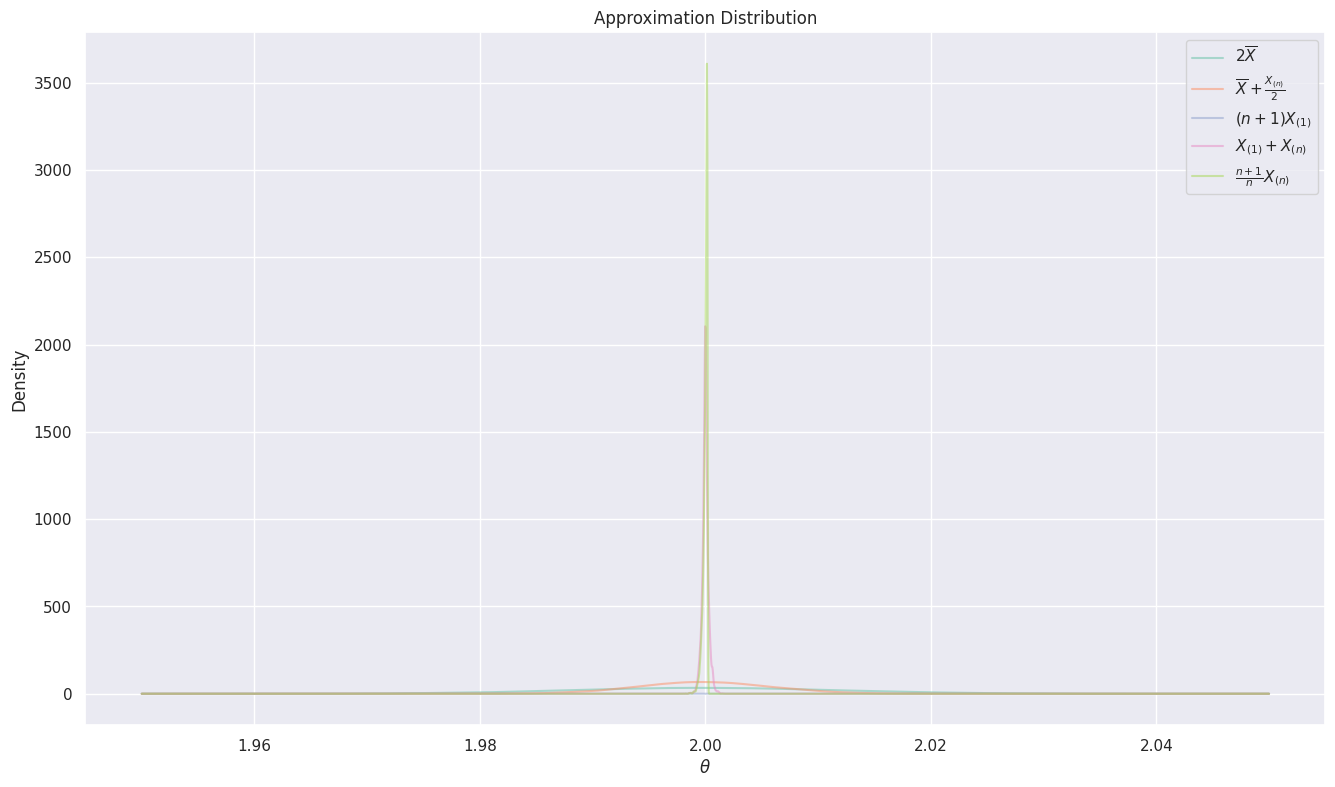

In [31]:
unf_fig, unf_axs = make_plot(xlabex=r'$\theta$', ylabel=r'Density', title="Approximation Distribution")
for key, val in unf_apx.items():
    sns.lineplot(x=unf_grd["avg2"], y=sps.gaussian_kde(val[:, N - 1]).pdf(unf_grd["avg2"]), ax=unf_axs,
                 label=unf_key[key], alpha=0.5)
plt.show()

Сразу видим наиболее хорошие оценки: $X_{(1)} + X_{(n)}$ и $\frac{n+1}{n} X_{(n)}$. Их графики плотностей ощутимо выше остальных в районе $\theta = 2$. Самая плохая - $(n + 1) X_{(1)}$, кажется для нее был выбран нами слишком маленький масштаб

 Уменьшим масштаб для наиболее точных оценок:

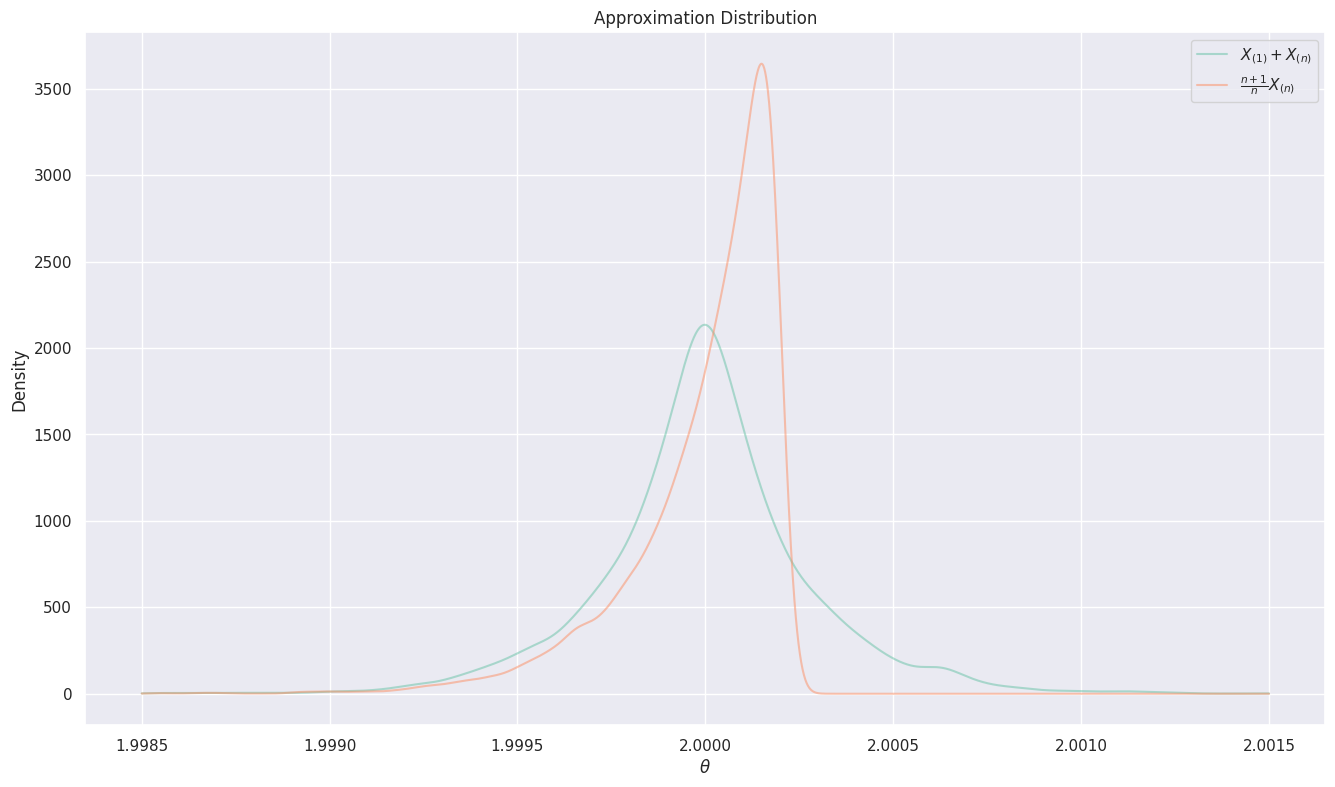

In [32]:
unf_grid_45 = np.linspace(1.9985, 2.0015, num=2500)
unf_fig_45, unf_axs_45 = make_plot(xlabex=r'$\theta$', ylabel=r'Density', title="Approximation Distribution")
sns.lineplot(x=unf_grd["mimx"], y=sps.gaussian_kde(unf_apx["mimx"][:, N - 1]).pdf(unf_grd["mimx"]), ax=unf_axs_45,
             label=unf_key["mimx"], alpha=0.5)
sns.lineplot(x=unf_grd["maxn"], y=sps.gaussian_kde(unf_apx["maxn"][:, N - 1]).pdf(unf_grd["maxn"]), ax=unf_axs_45,
             label=unf_key["maxn"], alpha=0.5)
plt.show()

Построим графики плотностей для $2 \overline{X}$ и $\overline{X} + X_{(n)} / 2$ отдельно для наибольшей информативности

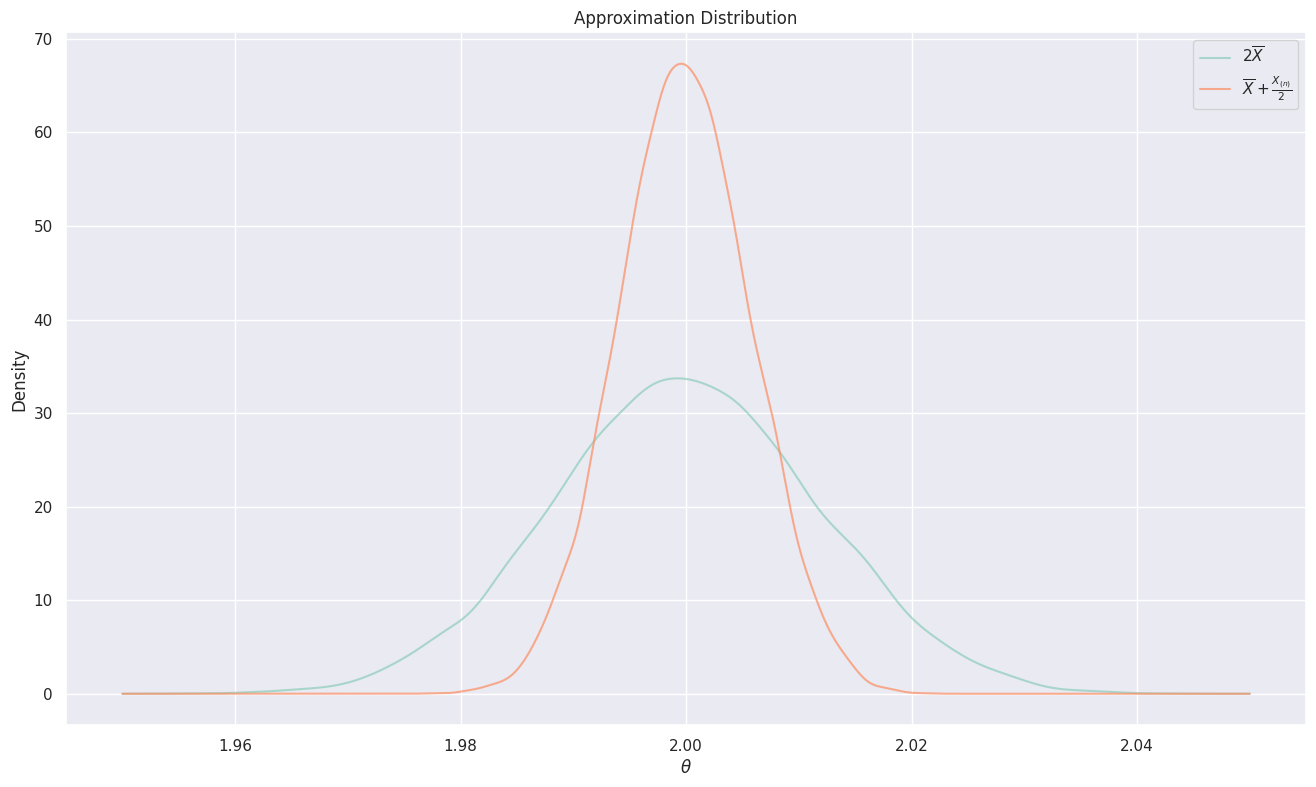

In [33]:
unf_fig_12, unf_axs_12 = make_plot(xlabex=r'$\theta$', ylabel=r'Density', title="Approximation Distribution")
sns.lineplot(x=unf_grd["avg2"], y=sps.gaussian_kde(unf_apx["avg2"][:, N - 1]).pdf(unf_grd["avg2"]), ax=unf_axs_12,
             label=unf_key["avg2"], alpha=0.5)
sns.lineplot(x=unf_grd["avgm"], y=sps.gaussian_kde(unf_apx["avgm"][:, N - 1]).pdf(unf_grd["avgm"]), ax=unf_axs_12,
             label=unf_key["avgm"], alpha=0.7)
plt.show()

Теперь так же для $(n + 1) X_{(1)}$

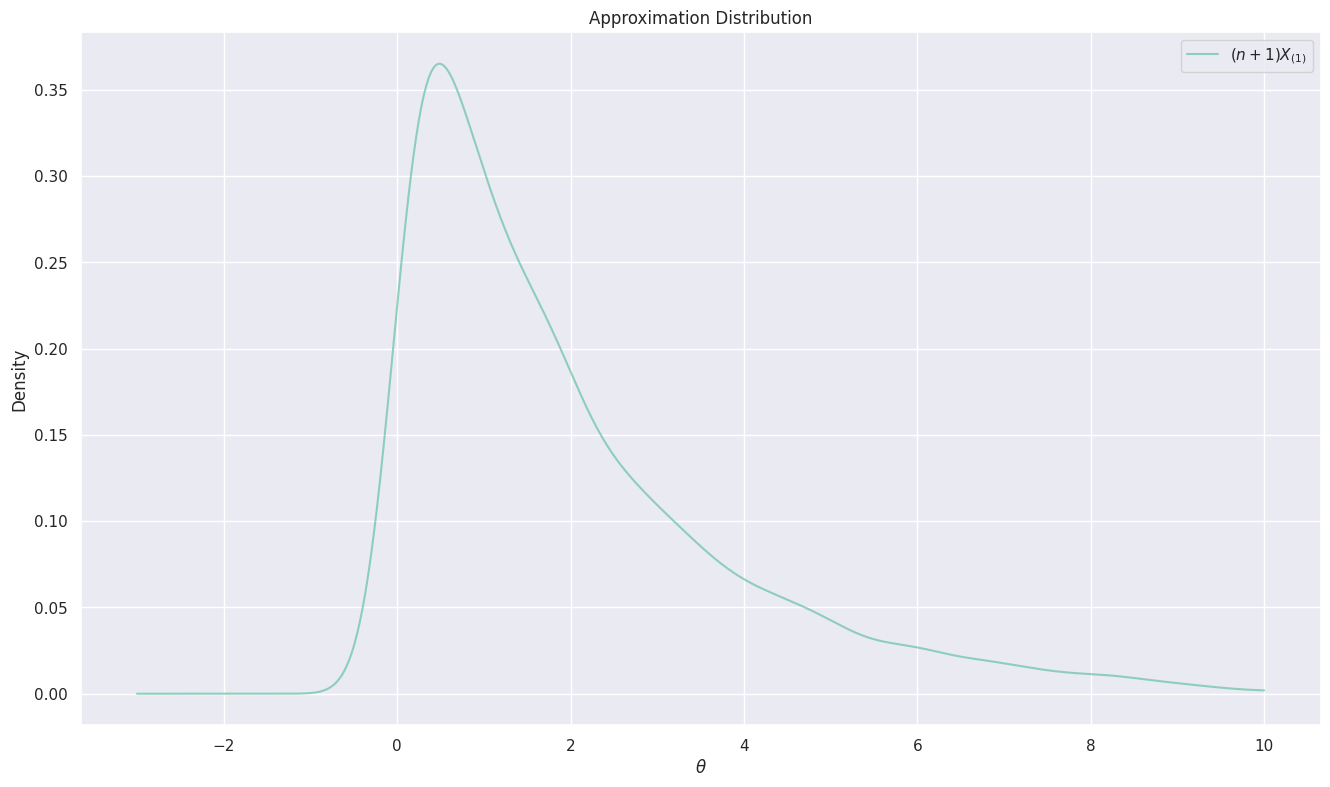

In [34]:
unf_grid_3 = np.linspace(-3, 10, num=2500)
unf_fig_3, unf_axs_3 = make_plot(xlabex=r'$\theta$', ylabel=r'Density', title="Approximation Distribution")
sns.lineplot(x=unf_grd["minn"], y=sps.gaussian_kde(unf_apx["minn"][:, N - 1]).pdf(unf_grd["minn"]), ax=unf_axs_3,
             label=unf_key["minn"], alpha=0.7)
plt.show()

Можем утверждать, что наиболее хорошими оценками являются $X_{(1)} + X_{(n)}$ и $\frac{n+1}{n} X_{(n)}$, так как для них значения сосредоточены сильно вблизи теоретического значения $\theta$, что видно по пикам на графиках плотности. Затем - $2 \overline{X}$, потом $\overline{X} + X_{(n)} / 2$. Самая худшая - $(n + 1) X_{(1)}$, кажется она вообще смещена в сторону 0.

Как меняется распределение каждой оценки с ростом параметра? Постройте оценки не только по выборкам, но и по их префиксам. В качестве размера префикса возьмите хотя бы 4 значения, меньших N.

__Подсказка:__ Могут быть полезными функции `np.arange`, `np.cumsum`, `np.maximum.accumulate` и `np.minimum.accumulate`

Изучите оценки на состоятельность и нормальность. Сравните скорости сходимости.

Построим графики того, как меняются распределения оценок с ростом параметра

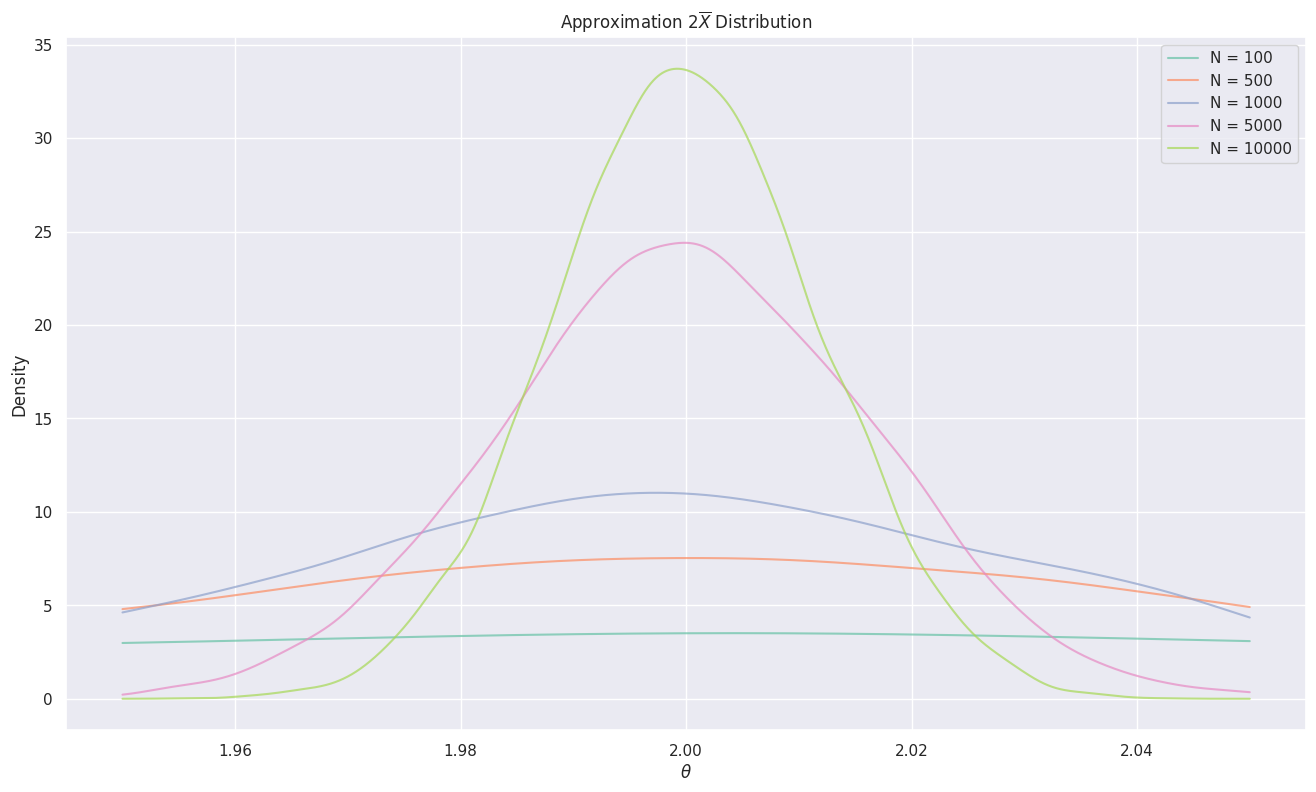

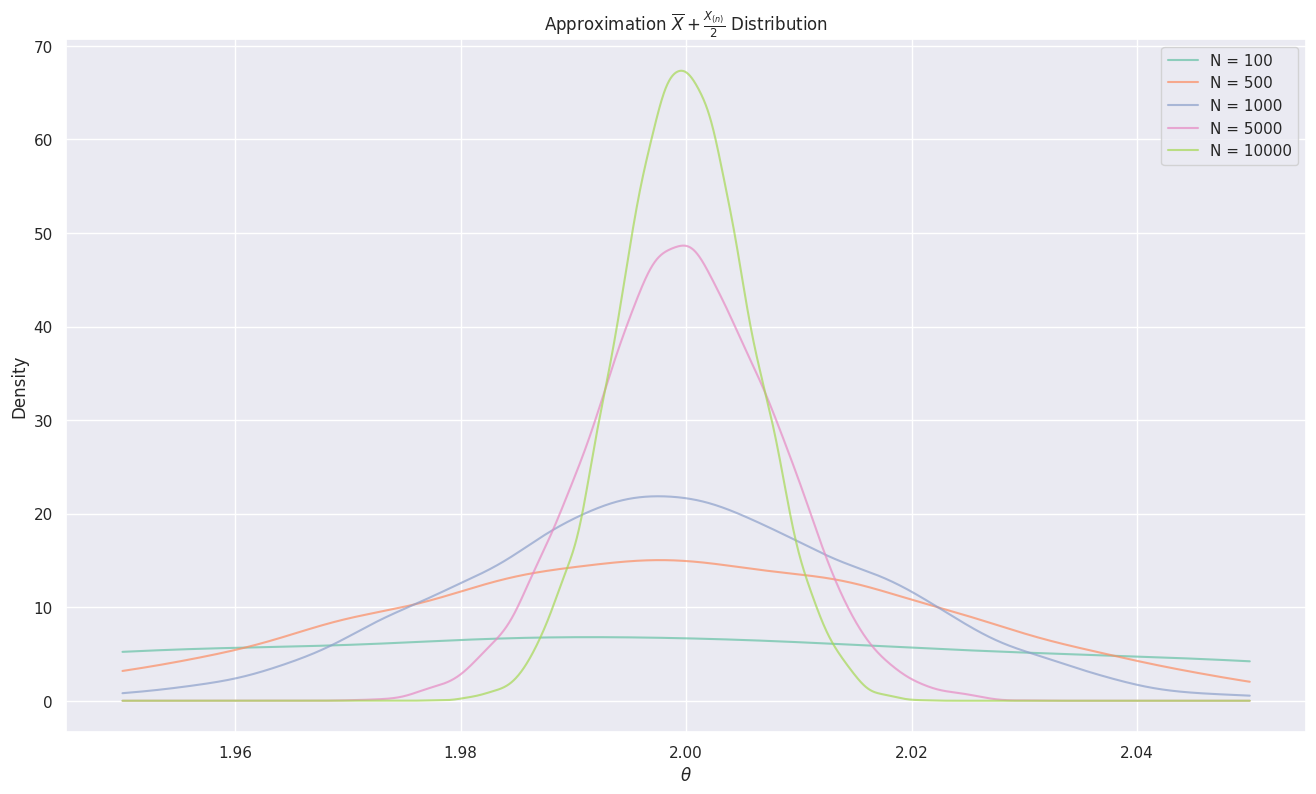

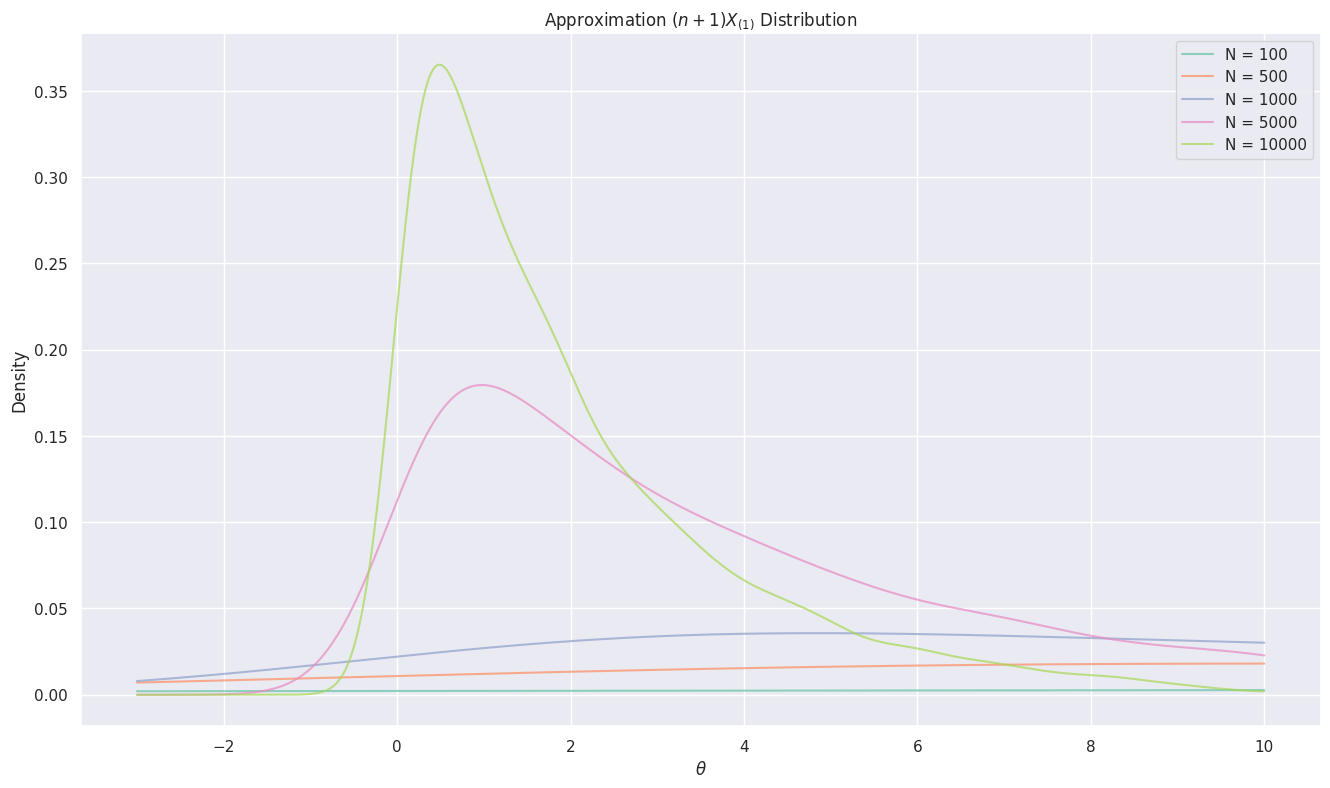

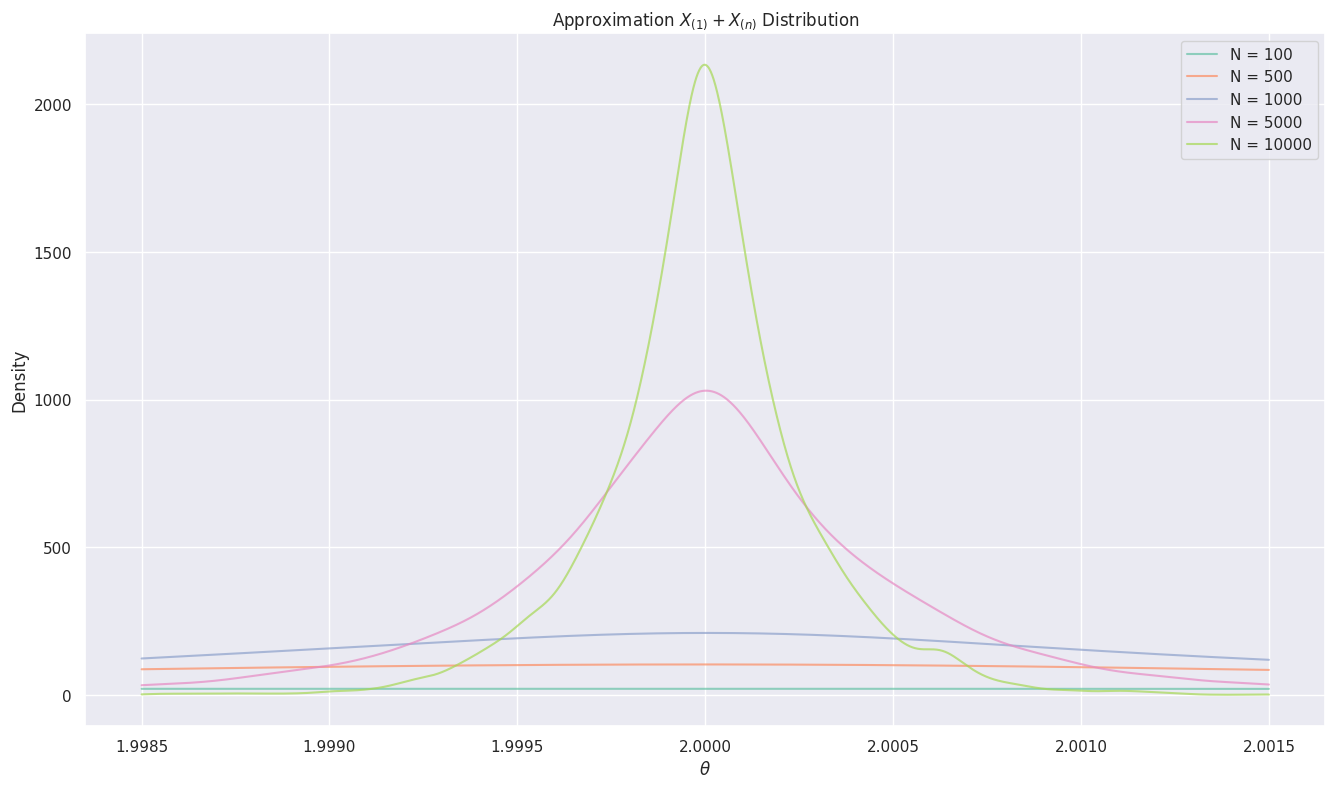

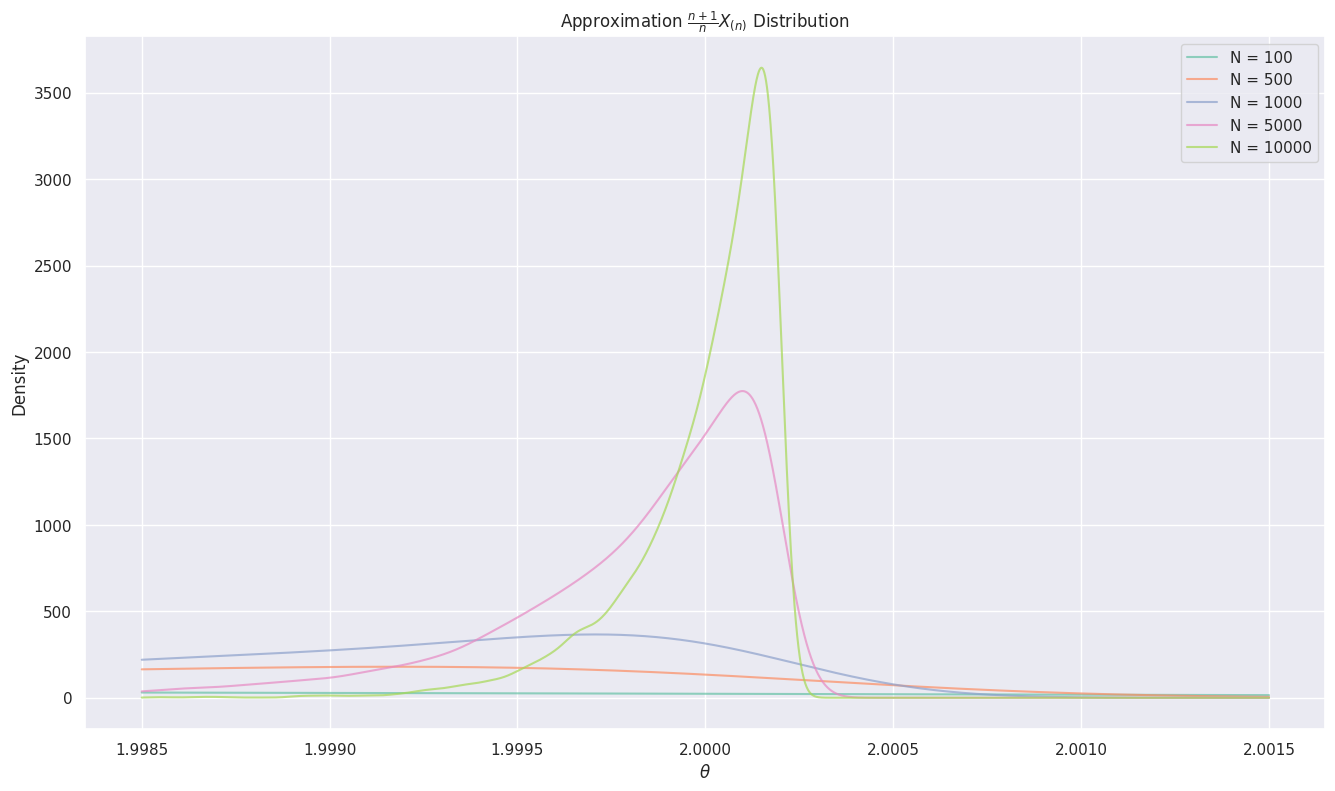

In [35]:
unf_par_plots = {key: make_plot(xlabex=r'$\theta$', ylabel=r'Density',
                                title=rf'Approximation {unf_key[key]} Distribution') for key in unf_key.keys()}

for key, value in unf_apx.items():
    for n in VAR:
        sns.lineplot(x=unf_grd[key], y=sps.gaussian_kde(unf_apx[key][:, n - 1]).pdf(unf_grd[key]),
                     ax=unf_par_plots[key][1], label=f"N = {n}", alpha=0.7)

Как мы видим, с ростом параметра все графики распределений оценок, кроме $(n + 1) X_{(1)}$, приближаются к $\theta = 2$, увеличиваясь в плотности в данной точке и изменяя форму в сторону точечного столба, в силу чего данные 4 оценки являются состоятельными. Оценка $(n + 1) X_{(1)}$ оказалась смещенной и не состоятельной, так как с ростом $N$ пик плотности все больше удаляется от $\theta = 2$. Проверим на нормальность

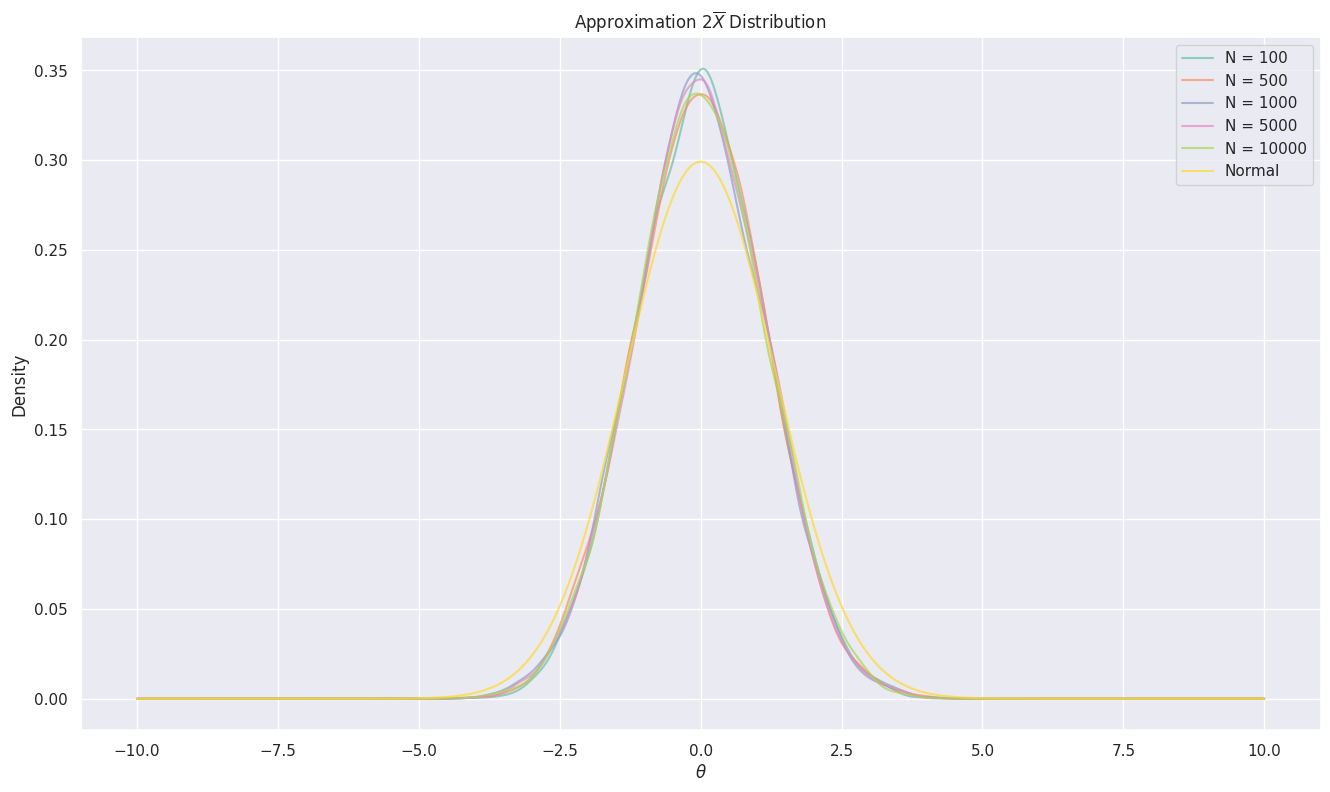

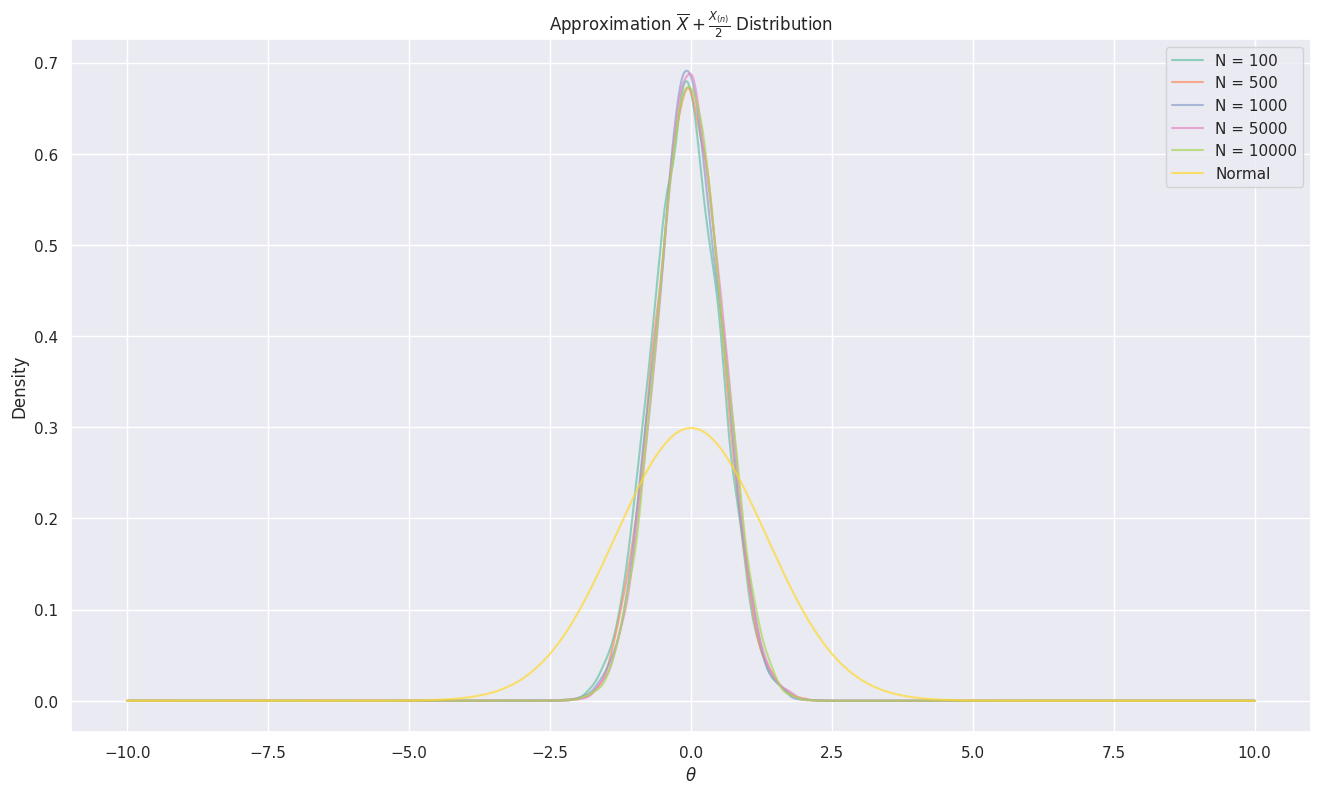

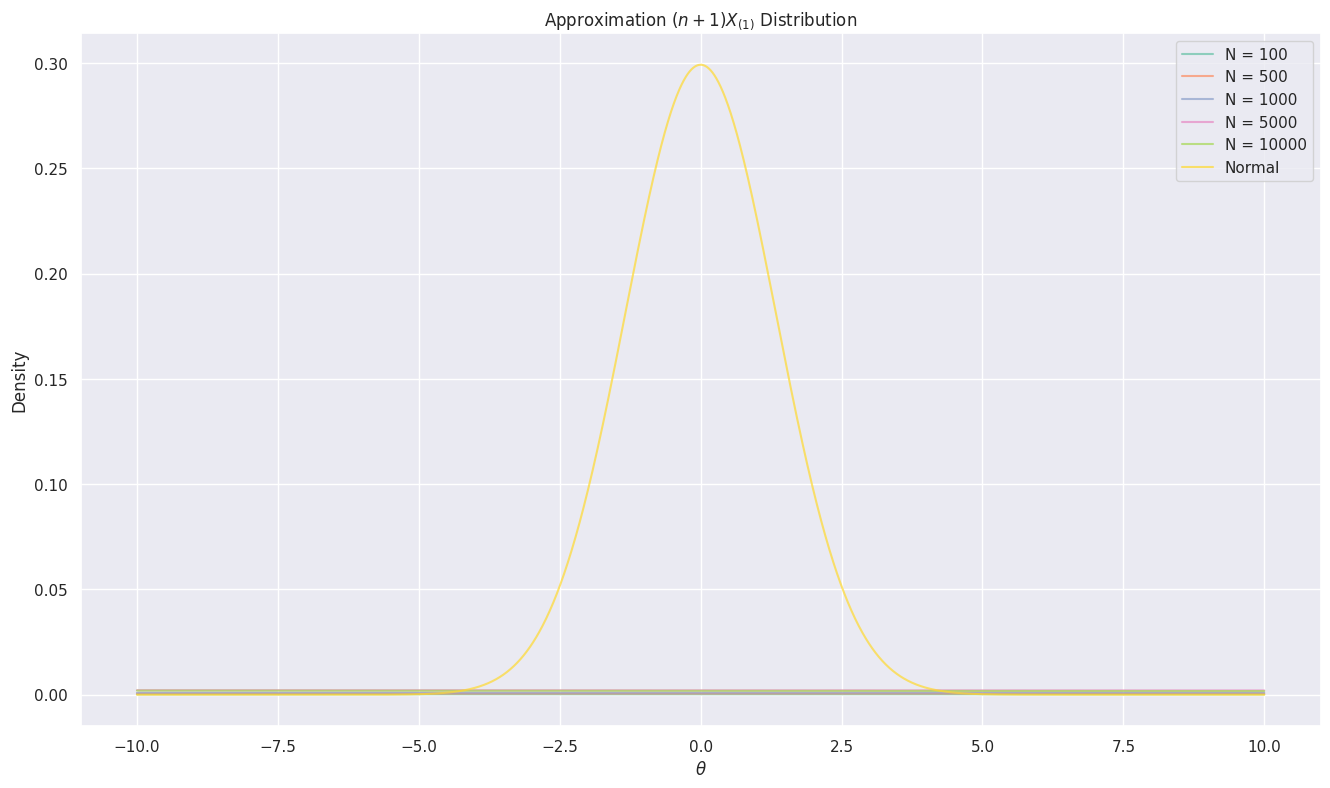

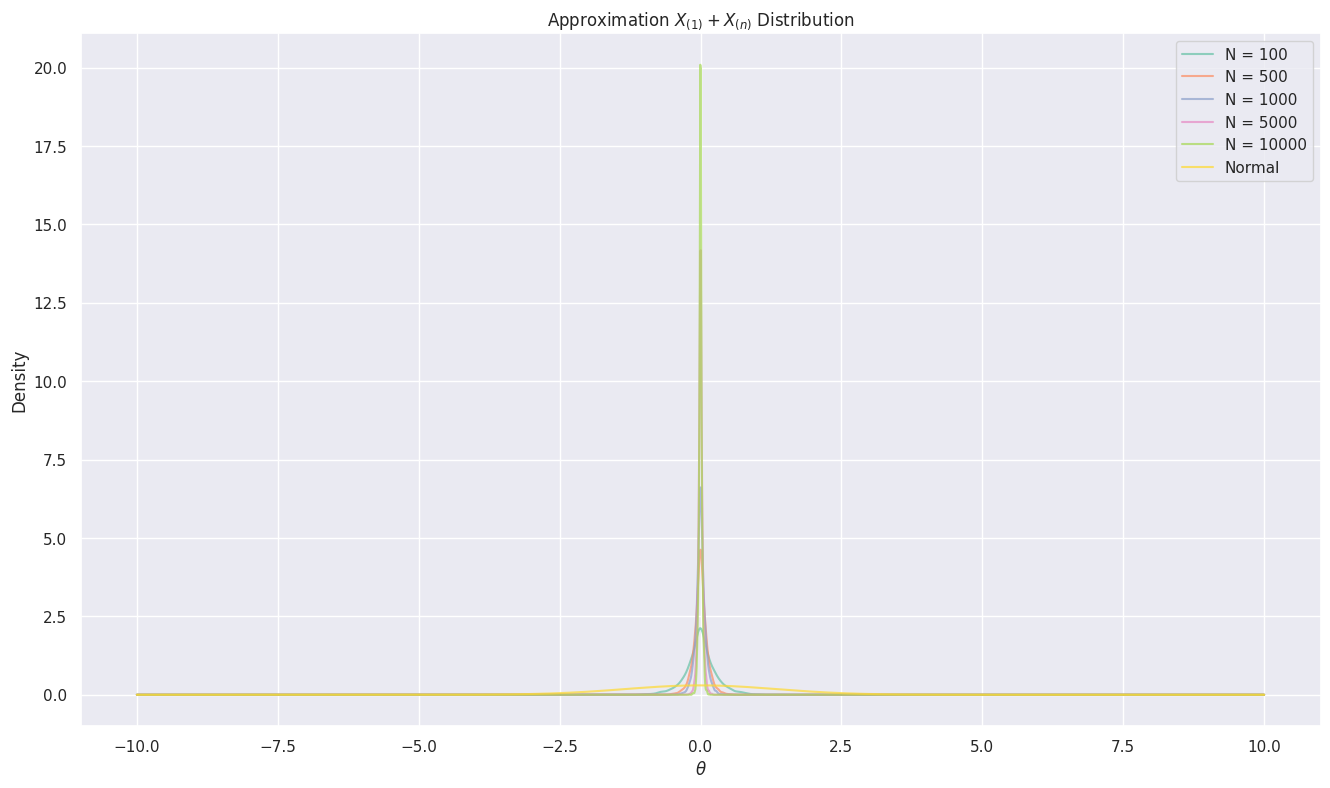

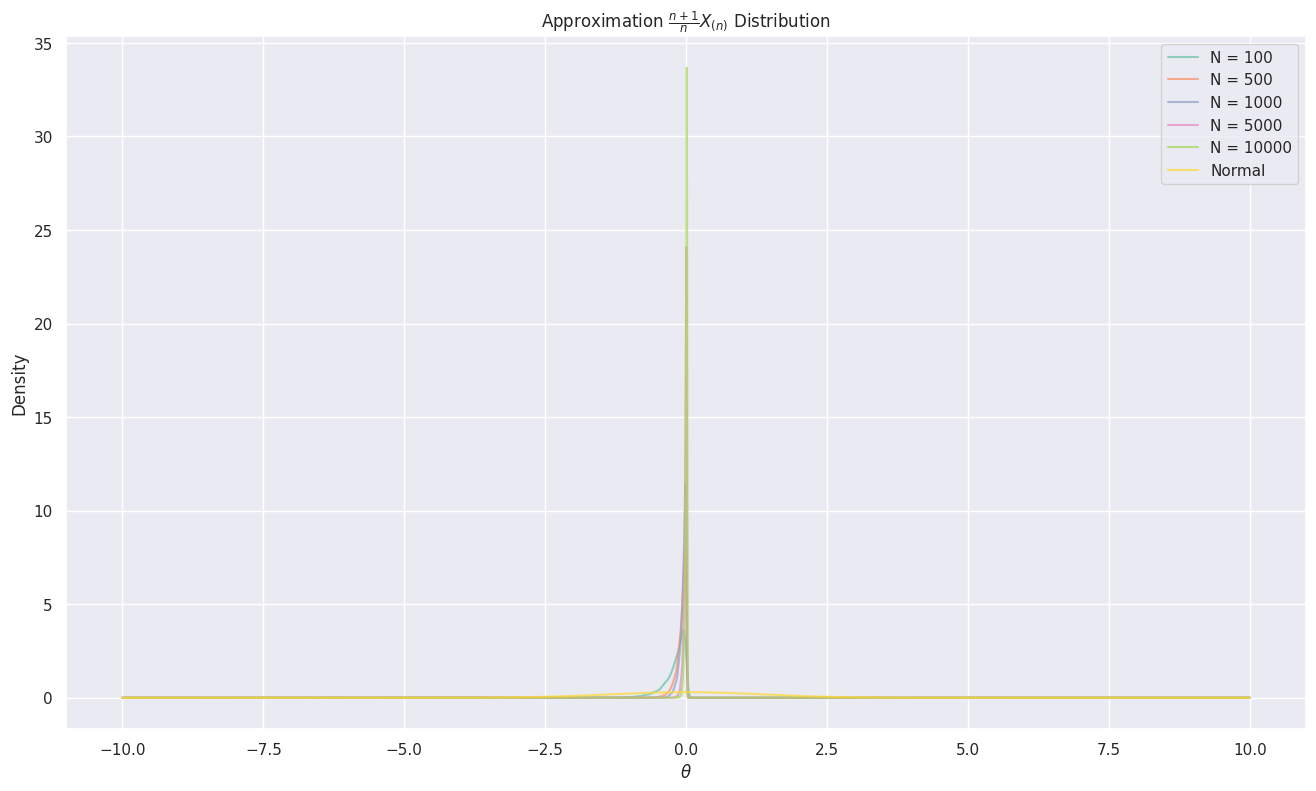

In [47]:
unf_nor_plots = {key: make_plot(xlabex=r'$\theta$', ylabel=r'Density',
                                title=rf'Approximation {unf_key[key]} Distribution') for key in unf_key.keys()}

nor_grd = np.linspace(-10, 10, num=2500)

for key, value in unf_apx.items():
    for n in VAR:
        sns.lineplot(x=nor_grd,
                     y=sps.gaussian_kde(np.sqrt(n) * (unf_apx[key][:, n - 1] - UNF_THETA)).pdf(nor_grd),
                     ax=unf_nor_plots[key][1], label=f"N = {n}", alpha=0.7)
    sns.lineplot(x=nor_grd, y=sps.norm(loc=0, scale=4 / 3).pdf(nor_grd),
                 ax=unf_nor_plots[key][1], label=f"Normal", alpha=0.7)

Какая оценка получилась лучше? Как Вы это поняли? А что говорит теория? Стоит ли в данной ситуации сравнивать оценки для других значений параметра $\theta$?

__Ответ:__


Сделайте вывод.


__Вывод:__

### Задача 2

Конрийские провинции известны своими пастбищами и скотоводами. Принц Нерсей Пройас замерил, что количество скота подчиняется экспоненциальному распределению с параметром $\lambda = 1$ (в тысячах голов). Для подсчёта оценки параметра есть семейство оценок $(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$, каждая следующая из которых требует большего числа операций на вычисление. Стоит ли оно того? Это и нужно выяснить.

В этой задаче Вы научитесь подбирать гиперпараметр к семейству оценок. Как известно из основного курса статистики, для любого $k$ оценка  $(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$ является состоятельной и асимптотически нормальной. Но какой $k$ стоит выбрать?

Сгенерируйте $N$ выборок $X_1, ..., X_N$ размера $n$ из экспоненциального распределения с параметром $\lambda = 1$ для $N = n = 10^4$.

Для всех выборок посчитайте оценку $\widehat{\lambda}_k=(\frac{k!}{\overline{X^k}})^{\frac{1}{k}}$ параметра $\lambda$. Проведите исследование, аналогичное предыдущей задаче, и выясните, при каком k оценка ведет себя лучше (рассмотрите не менее $10$ различных значений $k$).

Являются ли данные оценки асимптотически нормальными? Проверьте это теоретически и моделированием -- постройте эмпирическую плотность распределения статистик $\sqrt{n}\left(\widehat\lambda_k - \lambda\right)$.

Посчитайте дисперсию оценок для разных $k$ и разных размеров выборки. Сходится ли она к теоретической? Что Вы можете сказать о скорости сходимости?

На одном графике изобразите плотности распределений оценок для разных $k$ и на основе графика сделайте выбор параметра. Обоснуйте его.

Для одной выборки постройте графики $\left|\hat{\lambda}_k - \lambda\right|$ и сравните скорости сходимости к нулю при увеличении размера выборки.

Сделайте вывод.


__Вывод:__

### Задача 3

Кианские провинции до сих пор надеются отделиться от Новой Империи, и поэтому планируют саботировать Ордалию. К их счастью, число урожая в пустынных землях на юге подчиняется распределению Коши, которое отличается существенно от двух распределений из задач 1 и 2. Чем отличается? Как это повлияет на оценивание его параметра сдвига?

В этой задаче Вам нужно показать на примере, как построение интуитивно понятной оценки без теоретического обоснования может дать неадекватный результат.

Ниже напишите, какое поведение Вы ожидаете от оценки среднего и медианы. Обоснуйте ожидания, ссылаясь на теоремы и задачи из курса теории вероятностей:

Ответ:

Для распределения Коши моделированием изучите поведение оценки параметра сдвига при помощи среднего и медианы. У какой из этих оценок лучше асимптотические свойства?

Проверьте свои теоретические ожидания, написанные в начале задачи. Моделированием проверьте, какие оценки состоятельны и асимптотически нормальны.

Изучите поведение эмпирической дисперсии оценок среднего и медианы. Какая из них сходится? С какой скоростью? Для проверки постройте график какой-то детерминированной функции с такой же скоростью сходимости.

**Вывод:**

### Задача 4

Древние свитки из Сареотской библиотеки хранят знания двух древних волшебников севера --- Гливенко и Кантелли. Два мага-гностика придумали ультимативный способ оценивания распределений количества чего угодно. Их способом пользовались короли севера ещё две тысячи лет назад, во времена Первой Ордалии. Аспект-Император отдал приказ проверить, верны ли их выкладки до сих пор.

Эта задача посвящена проверке теоремы Гливенко-Кантелли, как основного теоретического результата курса. Условия посмотрите в методичке или сходите на лекцию старшего магистра колдовства и чародейства Савёлова М.П.

Сгенерируйте $N$ выборок $X_1,\dots, X_N$ размера $N$ из стандартного нормального распределения для $N = 10^4$.

In [ ]:
np.random.seed(42)

Для всех $n \leqslant N$ первой выборки посчитайте эмпирическую функцию распределения.


In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF  # can be useful, but not necessary

ecdfs: typing.List[ECDF] = [ECDF(X.sample[:i]) for i in range(1, len(X) + 1)]

Для некоторых $n$ (например, $n \in \{10,25,50,100,1000,N\}$ постройте графики эмпирической функции распределения (отметьте на оси абсцисс точки "скачков" кривых, нанеся каждую из "подвыборок" на ось абсцисс на каждом соответствующем графике с коэффициентом прозрачности `alpha=0.2`) и сравните каждый из них с истинной функцией распределения (количество графиков равно количеству различных значений $n$).

Проверьте выполнение теоремы Гливенко-Кантелли.

Для всех $n ≤ N$ посчитайте значение $D_n = \displaystyle{\sup_{x \in \mathbb R}} | \hat{F}_n(x) - F(x)|$ для первой выборки. Промоделируйте поведение статистики $\sqrt{n}D_n$. Наблюдается ли сходимость их распределений на графиках?


Пища для ума: если Ваша эмпирическая плотность сходится к чему-то, то это не просто так! Поищите на просторах интернета, учебников и бесед с умными людьми, куда должна сходиться статистика $\sqrt{n}D_n$. Подумайте, для чего может быть полезен этот теоретический результат.

Ответ:

Сделайте вывод о важности теоремы Гливенко-Кантелли в численном анализе. Какие методы, применяемые Вами в других задачах неявно основываются на этой теореме?

**Вывод:**

### Задача 5

Оказывается, нельзя оценивать распределения оценок на глаз простым всматриванием в графики! Поэтому гностики из крепости Нрон изобрели новое заклинание -- QQ-plot. В этой задаче Вам предстоит научиться проверять распределения на принадлежность семействам при помощи этого инструмента.

В этой задаче Вам предлагается изучить инструмент QQ-plot и сделать на его основе выводы о равенстве распределений.

Сгенерируйте $N_{\text{samples}}=400$ выборок из равномерного распределения $\mathrm U{[0, \theta]}$ для $\theta=1$ размера $n=40$. Моделированием статистик $\hat\theta = 2\overline{X}, \ \theta^* = \frac{n+1}{n} X_{(n)}$ изучите их распределение. Постройте гистограмму получившихся значений каждой из статистик на одном графике, в качестве параметра `bins` функции `plt.hist` передайте значение ниже, а таккже передайте параметр `alpha=0.6`.

Указание: можно взять код и результаты из задачи 1. Просто скопируйте их сюда.

In [ ]:
N_samples = 400
n = 40

bins = [i / 40 + 0.8 for i in range(18)]

Промоделируйте статистики $\sqrt{n} (\hat\theta - \theta)$ и $1 - n  (\theta^* - \theta)$. К чему сходятся их распределения с ростом $n$?

На какие распределения похожи получившиеся гистограммы?

**Ответ:**

Вспомните, чему равен коэффициент $\sigma^2(\theta)$ для асимптотически нормальной оценки $\hat\theta = 2\overline{X}$ параметра $\theta$ равномерного распределения в формуле
$$
\sqrt{n}\frac{\left(\hat\theta - \theta\right)}{\sqrt{\sigma^2(\theta)}} \xrightarrow{d} \mathcal N(0, 1).
$$

**Ответ**:

Посчитайте статистику
$$\sqrt{n}\frac{\left(\hat\theta - \theta\right)}{\sqrt{\sigma^2(\theta)}}$$ для каждой выборки. Постройте её плотность теоретически и при помощи KDE.

Для быстрой проверки гипотезы о том, что выборка принадлежит какому-либо распределению, часто используется инструмент под названием `QQ-plot` (первые буквы означают `Quantile`). На нем по оси $x$ отложены теоретические значения квантиля, а по оси $y$ -- квантили тестируемой выборки. Очевидно, в идеале такие квантили должны совпадать, поэтому на графике можно увидеть красную линию соответствующую графику функции $y = x$.

Изучите семинарский ноутбук ноль и постройте QQ-plot предложенной статистики и нормального распределения.

Сделайте вывод по графику выше. Можно ли утверждать, что выборка взята из нормального распределения?

**Ответ:**

Вернемся к статистике $\theta - n  (\theta^* - \theta)$. Еще раз взгляните на гистограмму, соотвутствующую этой статистике. Попробуйте построить `QQ-plot` для различных распределений (например можно передать в параметр `dist=sps.uniform` в функцию `sm.qqplot` или любое другое из модуля `scipy.stats`). Какое распределение подходит лучше всего?

**Ответ:**

Бонусная часть (+5 баллов): Если Вы нашли семейство распределений, которое по QQ-plot соответствует выборке, то докажите строго, что $n(\theta^* - \theta)$ сходится к нему. Заметьте, что это утверждение от асимптотической нормальности отличается только заменой $\sqrt{n}$ на $n$. Такие оценки называются **сверхнормальными**. В конце доказательства поясните:

- как множитель, зависящий от $n$, связан с скоростью сходимости оценки на практике?
- лучше ли сверхномальная оценка, чем нормальная оценка?

**Решение:**

Плохо ли, что оценка $\theta^*$ не асимптотически нормальна? Сделайте вывод о скорости сходимости оценок. Какая из них «выгоднее»?

**Ответ:**

Не забудьте перезапустить с нуля весь ноутбук перед отправкой! Удачи.